# NDA_COURSEWORK Part 1

In [1]:
# importing the necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

import ndlib.models.epidemics.SIRModel as sir
import ndlib.models.ModelConfig as config

## Task A

### Step 1: Load Dataset  
This function reads a CSV file containing the Wikidata Talk page dataset into a pandas DataFrame. Each row corresponds to a user comment on a thread within a page.

In [ ]:
def load_dataset(file_path):
    data_set = pd.read_csv(file_path) # reads a csv file in a pandas dataframe
    return data_set

### Step 2: Assign Unique Node IDs  
Each unique username is assigned a numerical ID to use in the graph structure. This is helpful for efficiency in graph construction and analysis.

In [ ]:
def assign_node_ids(df):
    unique_users = df["username"].unique() # getting unique users from data frame
    return {user: ids for ids, user in enumerate(unique_users)} # Returns a dictionary, containing a Mapping of username to unique integer node ID.

### Step 3: Construct the Editor Network  
This function creates an undirected graph where nodes are users. An edge is added between two users if they commented on the same thread of the same page. It also attaches the following attributes to each Node:

- Username

- Total comments

- Number of unique pages

- Number of unique threads.

In [ ]:
def construct_wikidata_editor_network(df, user_id_map):
    G = nx.Graph()

    # Counting the total number of comments per user
    user_comment_counts = df["username"].value_counts().to_dict()

    # Storing the number of unique pages and threads per user
    user_pages = df.groupby("username")["page_name"].nunique().to_dict()
    user_threads = df.groupby("username")["thread_subject"].nunique().to_dict()

    # Creating an empty adjacency list to store connections
    adjacency = {}

    # Grouping by page_name and thread_subject to find users interacting in the same thread
    grouped_users = df.groupby(["page_name", "thread_subject"])["username"]
    
    for _, users in grouped_users:
        users = set(users)
        for user in users:
            if user not in adjacency:
                adjacency[user] = set()
            adjacency[user].update(set(users) - {user})
            
    # Iterating over each group of users who commented in the same thread and page
    for _, users in grouped_users:
        users = set(users)  # Converting to set to remove any duplicates
        
        for user in users:
            # Initializing adjacency list for the user if not already present
            if user not in adjacency:
                adjacency[user] = set()
            
            # Adding all other users in the same thread as neighbors, This creates undirected edges between all people who commented in the same thread
            adjacency[user].update(users - {user}) # subtracting user to exclude self from adjacency
    
    

    # Adding nodes and edges to the graph with attributes
    for user, neighbors in adjacency.items():
        G.add_node(user_id_map[user],
                username=user, 
                total_comments=user_comment_counts.get(user, 0),
                unique_pages=user_pages.get(user, 0),
                unique_threads=user_threads.get(user, 0)
                )
        for neighbor in neighbors:
            G.add_edge(user_id_map[user], user_id_map[neighbor])
    
    return G


### Step 4: Visualize the Network  
This function plots the constructed editor network. Nodes represent editors, and edges indicate co-participation in the same thread on a page.

In [ ]:
def visualize_network(G, title=""):
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G, seed=42)  # Positioning nodes
        nx.draw(G, 
                pos,
                node_size=50,                  
                node_color="skyblue",   # Fill color
                edge_color="black",     # Edge color
                edgecolors="black",     # Node border color
                alpha=0.6,
                with_labels=False
        )
        plt.title(title)
        plt.show()

### Step 5: Interactive Network Visualization  
This function uses Bokeh to render an interactive version of the editor network implemented in Lab 2 of NDA. You can zoom, pan, and inspect the graph dynamically in the browser.

In [ ]:
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, from_networkx
output_notebook()
from bokeh.palettes import Spectral4
from bokeh.models import (
    Plot, Range1d, Circle, MultiLine, 
    HoverTool, TapTool, BoxZoomTool, WheelZoomTool, 
    PanTool, ResetTool, NodesAndLinkedEdges, EdgesAndLinkedNodes
)

def interactive_network_plot(G, title=""):
    plot = Plot(width=800, height=400,
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = title

    # Add interactive tools
    plot.add_tools(
        HoverTool(tooltips=None),
        TapTool(), BoxZoomTool(), WheelZoomTool(),
        PanTool(), ResetTool()
    )

    # Use a spring layout
    graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0, 0))

    # Style nodes
    graph_renderer.node_renderer.glyph = Circle(radius=0.008, fill_color=Spectral4[0])
    graph_renderer.node_renderer.selection_glyph = Circle(radius=0.015, fill_color=Spectral4[2])
    graph_renderer.node_renderer.hover_glyph = Circle(radius=0.008, fill_color=Spectral4[1])

    # Style edges
    graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=1)
    graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=1)
    graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=1)

    # Define interaction behavior
    graph_renderer.selection_policy = NodesAndLinkedEdges()
    graph_renderer.inspection_policy = EdgesAndLinkedNodes()

    # Add graph to plot
    plot.renderers.append(graph_renderer)

    # Display the plot
    show(plot)

Loading BokehJS ...

### Step 6: Construct and Visualize Small, Medium, and Large Wikidata Editor Networks

We construct three user interaction networks based on file sizes:
- **Small**: `BOT_REQUESTS.csv`
- **Medium**: `ITEMS.csv`
- **Large**: `REQUEST_FOR_DELETION.csv`

Each dataset is loaded, processed into a network graph, and visualized using both static and interactive visualizations.

#### 6.1 Constructing and Visualizing Small Size Network

In [ ]:
small_size_data_frame = load_dataset("../data/part1/BOT_REQUESTS.csv") # This file is selected because it had the smallest size.
user_id_map = assign_node_ids(small_size_data_frame) # Assigning node ids
small_size_graph_network= construct_wikidata_editor_network(small_size_data_frame,user_id_map) # constructing small size network

##### Inspecting Node Attributes
To verify the construction of the network and the assignment of node attributes , we print the attributes of the first 5 nodes in the small-sized network.

In [38]:
count = 0
for node, attrs in small_size_graph_network.nodes(data=True):
    print(f"Node ID: {node}, Attributes: {attrs}")
    count += 1
    if count >= 5:  # Change 5 to any number you want
        break

Node ID: 322, Attributes: {'username': 'Epìdosis', 'total_comments': 16, 'unique_pages': 9, 'unique_threads': 16}
Node ID: 526, Attributes: {'username': 'BrokenSegue', 'total_comments': 8, 'unique_pages': 4, 'unique_threads': 8}
Node ID: 277, Attributes: {'username': 'Pyfisch', 'total_comments': 29, 'unique_pages': 15, 'unique_threads': 28}
Node ID: 518, Attributes: {'username': 'Sapfan', 'total_comments': 2, 'unique_pages': 2, 'unique_threads': 2}
Node ID: 503, Attributes: {'username': 'OsamaK', 'total_comments': 1, 'unique_pages': 1, 'unique_threads': 1}


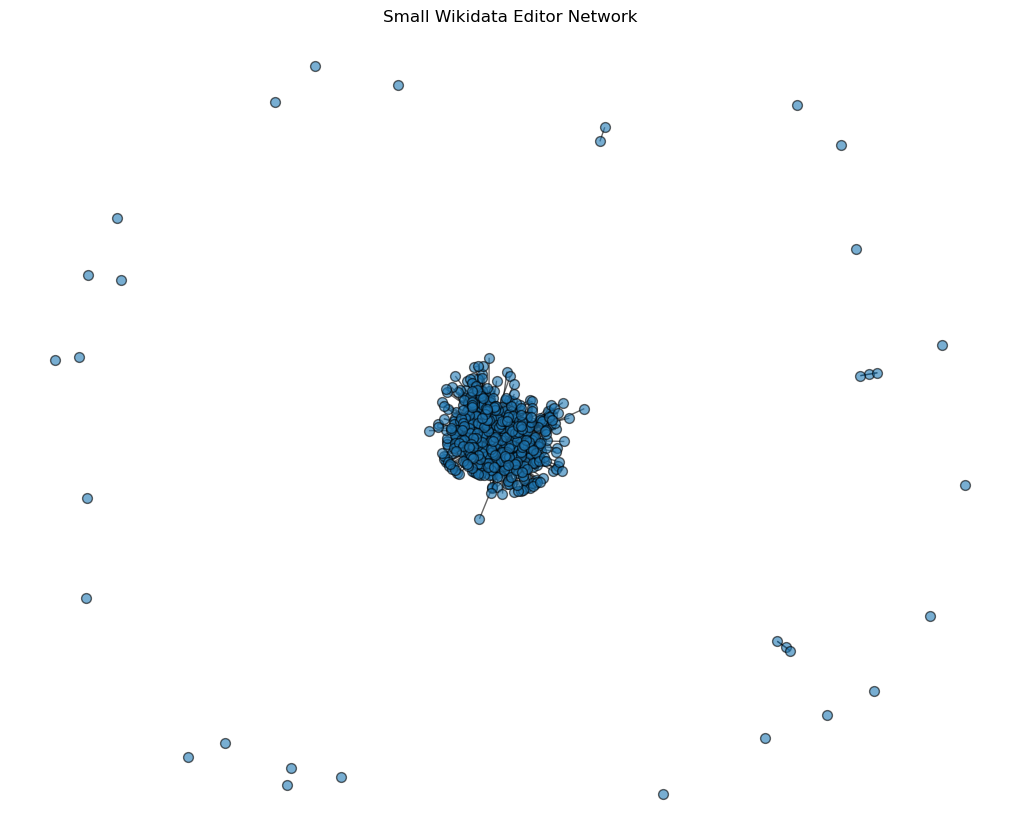

In [34]:
visualize_network(small_size_graph_network, "Small Wikidata Editor Network")

In [ ]:
interactive_network_plot(small_size_graph_network, "Small Wikidata Editor Network") # Drag to view entire network

#### 6.2 Constructing and Visualizing Medium Size Network

In [ ]:
medium_size_data_frame = load_dataset("../data/part1/ITEMS.csv") # This file was selected because it had size in between the largest and smallest file
user_id_map = assign_node_ids(medium_size_data_frame) # Assigning node ids
medium_size_graph_network= construct_wikidata_editor_network(medium_size_data_frame,user_id_map) # constructing medium size network

##### Inspecting Node Attributes
To verify the construction of the network and the assignment of node attributes , we print the attributes of the first 5 nodes in the medium-sized network.

In [ ]:
count = 0
for node, attrs in medium_size_graph_network.nodes(data=True):
    print(f"Node ID: {node}, Attributes: {attrs}")
    count += 1
    if count >= 5:
        break

Node ID: 105, Attributes: {'username': 'Infovarius', 'total_comments': 1091, 'unique_pages': 1023, 'unique_threads': 536}
Node ID: 1635, Attributes: {'username': 'Ksc~ruwiki', 'total_comments': 2, 'unique_pages': 2, 'unique_threads': 2}
Node ID: 493, Attributes: {'username': 'थकुराःमा', 'total_comments': 5, 'unique_pages': 5, 'unique_threads': 2}
Node ID: 1083, Attributes: {'username': 'Somerby', 'total_comments': 2, 'unique_pages': 2, 'unique_threads': 2}
Node ID: 1896, Attributes: {'username': 'MovGP0', 'total_comments': 2, 'unique_pages': 2, 'unique_threads': 2}


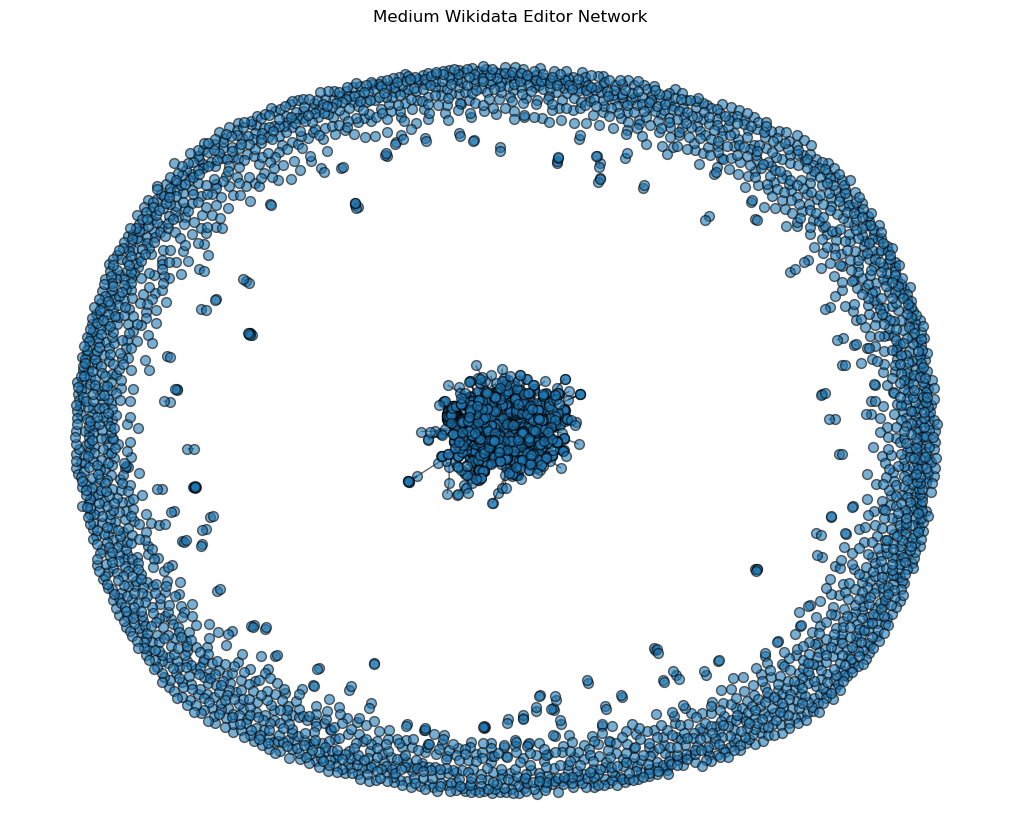

In [35]:
visualize_network(medium_size_graph_network, "Medium Wikidata Editor Network")

In [ ]:
interactive_network_plot(medium_size_graph_network, "Medium Wikidata Editor Network") # Drag to view entire network

#### 6.3 Constructing and Visualizing Large Size Network

In [ ]:
large_size_data_frame = load_dataset("../data/part1/REQUEST_FOR_DELETION.csv") # This file is selected because it had the largest size.
user_id_map = assign_node_ids(large_size_data_frame) # Assigning node ids
large_size_graph_network= construct_wikidata_editor_network(large_size_data_frame,user_id_map) # constructing large size network

##### Inspecting Node Attributes
To verify the construction of the network and the assignment of node attributes , we print the attributes of the first 5 nodes in the large-sized network.

In [ ]:
count = 0
for node, attrs in large_size_graph_network.nodes(data=True):
    print(f"Node ID: {node}, Attributes: {attrs}")
    count += 1
    if count >= 5: 
        break

Node ID: 9095, Attributes: {'username': 'Gymnicus', 'total_comments': 326, 'unique_pages': 134, 'unique_threads': 319}
Node ID: 4881, Attributes: {'username': 'Hannes Röst', 'total_comments': 30, 'unique_pages': 23, 'unique_threads': 30}
Node ID: 5010, Attributes: {'username': 'Hjart', 'total_comments': 23, 'unique_pages': 16, 'unique_threads': 23}
Node ID: 3064, Attributes: {'username': 'Bluerasberry', 'total_comments': 10, 'unique_pages': 7, 'unique_threads': 10}
Node ID: 514, Attributes: {'username': 'Lymantria', 'total_comments': 5727, 'unique_pages': 706, 'unique_threads': 5639}


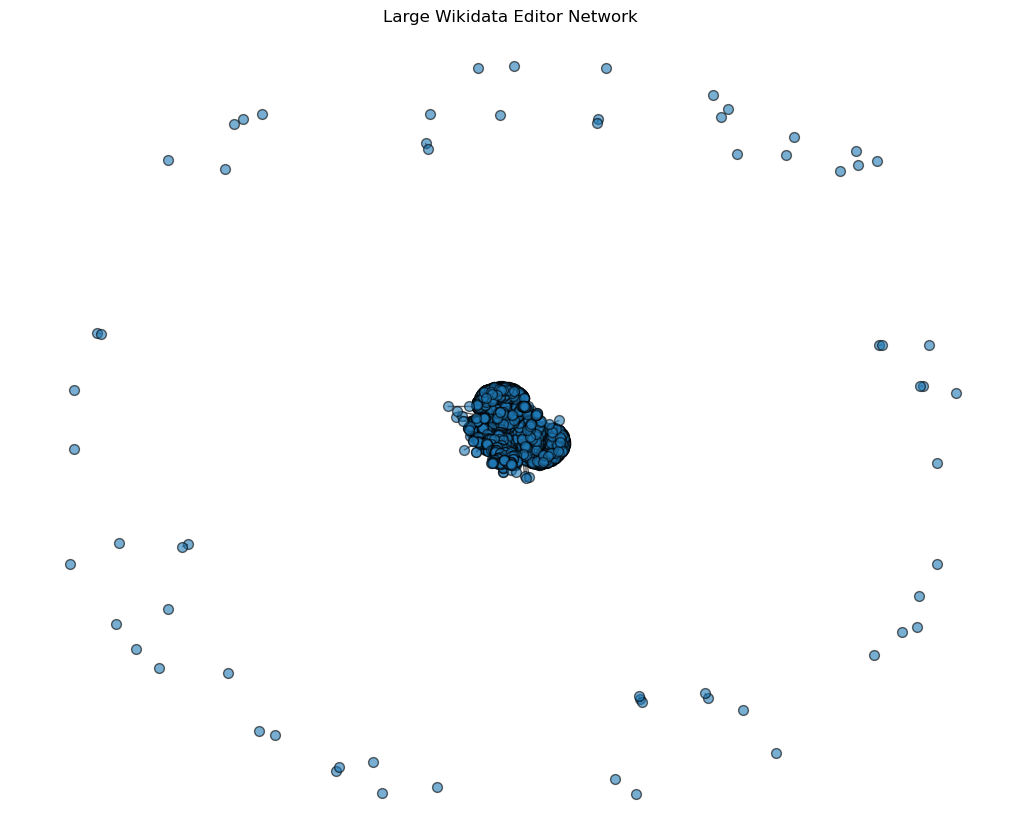

In [36]:
visualize_network(large_size_graph_network, "Large Wikidata Editor Network")

In [ ]:
interactive_network_plot(large_size_graph_network, "Large Wikidata Editor Network") # Drag to view entire network

## Task B

## Task C

## Task D